In [1]:
import os

import pandas as pd

from helpers.cell_type_naming import nice_to_weirds, weird_to_nice

# load data (truth, experiment results)

In [2]:
experiments_root = "csx_experiments/cell_type_grouping"

!tree -h -L 1 {os.path.join("/mnt/buckets/liulab", experiments_root)}

/mnt/buckets/liulab/csx_experiments/cell_type_grouping
├── [   0]  combine_lymphocytes
├── [   0]  combine_t_cells
├── [   0]  normal
└── [ 88M]  screfsamplemodified.txt

3 directories, 1 file


In [3]:
from pathlib import Path

p = Path(os.path.join("/mnt/buckets/liulab", experiments_root))

experiments = [f.name for f in p.iterdir() if f.is_dir()]
experiments

['combine_lymphocytes', 'combine_t_cells', 'normal']

In [4]:
def load_csx_results(experiment_uri):
    try:
        uri = os.path.join(experiment_uri, "CIBERSORTx_Results.txt")
        df = pd.read_csv(uri, sep="\t", index_col=0)
    except:
        uri = os.path.join(experiment_uri, "CIBERSORTx_Adjusted.txt")
        df = pd.read_csv(uri, sep="\t", index_col=0)
    df = df.iloc[:, :-3]  # ignore last three columns, which are test statistics
    df.rename(
        columns=weird_to_nice,
        inplace=True)
    df.index = df.index.astype(str)
    df.columns = list(sorted(df.columns))
    df.rename_axis(
        columns="cell_type",
        index="sample_id",
        inplace=True)
    if "Lymphocytes" not in df.columns:
        if "T" not in df.columns:
            # expects T CD4 and CD8 to exist!
            df["T"] = df[["T CD4", "T CD8"]].sum(axis="columns")
        df["Lymphocytes"] = df[["B", "NK", "T"]].sum(axis="columns")
    return df.stack()

In [5]:
load_csx_results("gs:///liulab/csx_experiments/cell_type_grouping/normal")

sample_id  cell_type  
53         B              0.047628
           CAF            0.030876
           Endothelial    0.056403
           Macrophage     0.299805
           Malignant      0.138433
                            ...   
94         NK             0.037556
           T CD4          0.468256
           T CD8          0.291373
           T              0.759629
           Lymphocytes    0.849827
Length: 190, dtype: float64

In [6]:
preds = dict()
# preds["derek"] = results_derek
# preds["me"] = results_docker
for experiment in experiments:
    try:
        experiment_uri = os.path.join("gs://liulab", experiments_root, experiment)
        pred_df = load_csx_results(experiment_uri)
        preds[experiment] = pred_df
    except FileNotFoundError:
        print("no results for", experiment, experiment_uri)

df_preds = pd.concat(
    preds,
    names=["experiment"],
    axis=0
).rename("csx_fraction")

# df_preds = df_preds.unstack("experiment")

df_preds

experiment           sample_id  cell_type  
combine_lymphocytes  53         CAF            0.016651
                                Endothelial    0.009814
                                Lymphocytes    0.040630
                                Macrophage     0.853234
                                Malignant      0.079670
                                                 ...   
normal               94         NK             0.037556
                                T CD4          0.468256
                                T CD8          0.291373
                                T              0.759629
                                Lymphocytes    0.849827
Name: csx_fraction, Length: 437, dtype: float64

In [7]:
truth = pd.read_csv(
    "gs://liulab/csx_example_files/groundtruth_Melanoma_Tirosh_et_al_SuppFig3b-d.txt",
    sep="\t",
    index_col=0
)
truth.rename(columns=weird_to_nice, inplace=True)
truth.index = truth.index.astype(str)
truth.columns = list(sorted(truth.columns))
truth.rename_axis(columns="cell_type", index="sample_id", inplace=True)
truth["T"] = truth[["T CD4", "T CD8"]].sum(axis='columns')
truth["Lymphocytes"] = truth[["B", "NK", "T CD4", "T CD8"]].sum(axis='columns')
truth = truth.stack().to_frame(name="true_fraction")
truth


true_fraction
sample_id cell_type                 
53        B                   0.1280
          CAF                 0.0880
          Endothelial         0.0320
          Macrophage          0.2000
          Malignant           0.0800
...                              ...
94        NK                  0.0083
          T CD4               0.3306
          T CD8               0.2686
          T                   0.5992
          Lymphocytes         0.6488

[190 rows x 1 columns]

In [8]:
all_results = truth.join(df_preds.unstack("experiment"), how="outer")

all_results.stack().unstack("cell_type")

cell_type                             B       CAF  Endothelial  Lymphocytes  \
sample_id                                                                     
53        true_fraction        0.128000  0.088000     0.032000     0.600000   
          combine_lymphocytes       NaN  0.016651     0.009814     0.040630   
          combine_t_cells      0.044113  0.024257     0.059771     0.141621   
          normal               0.047628  0.030876     0.056403     0.474483   
58        true_fraction        0.000000  0.000000     0.000000     0.317500   
...                                 ...       ...          ...          ...   
89        normal               0.191563  0.000462     0.001795     0.650853   
94        true_fraction        0.041300  0.078500     0.066100     0.648800   
          combine_lymphocytes       NaN  0.039364     0.072374     0.045954   
          combine_t_cells      0.047319  0.080560     0.048497     0.417590   
          normal               0.052642  0.074662     0.054631     0.849827   

cell_type                      Macrophage  Malignant        NK         T  \
sample_id                                                                  
53        true_fraction          0.200000   0.080000  0.096000  0.376000   
          combine_lymphocytes    0.853234   0.079670       NaN       NaN   
          combine_t_cells        0.576183   0.198168  0.097509  0.000000   
          normal                 0.299805   0.138433  0.082886  0.343968   
58        true_fraction          0.650800   0.031700  0.015900  0.301600   
...                                   ...        ...       ...       ...   
89        normal                 0.331568   0.015323  0.071638  0.387652   
94        true_fraction          0.202500   0.004100  0.008300  0.599200   
          combine_lymphocytes    0.754285   0.088023       NaN       NaN   
          combine_t_cells        0.453353   0.000000  0.044736  0.325536   
          normal                 0.003151   0.017730  0.037556  0.759629   

cell_type                         T CD4     T CD8  
sample_id                                          
53        true_fraction        0.376000  0.000000  
          combine_lymphocytes       NaN       NaN  
          combine_t_cells           NaN       NaN  
          normal               0.343968  0.000000  
58        true_fraction        0.285700  0.015900  
...                                 ...       ...  
89        normal               0.174191  0.213461  
94        true_fraction        0.330600  0.268600  
          combine_lymphocytes       NaN       NaN  
          combine_t_cells           NaN       NaN  
          normal               0.468256  0.291373  

[76 rows x 10 columns]

# evaluate experiments: correlations

In [9]:
truth.join(df_preds.unstack("experiment"), how="outer").corr()  #.sort_values(by="true_fraction", ascending=False)

,true_fraction,combine_lymphocytes,combine_t_cells,normal
true_fraction,1.000000,0.138589,0.758198,0.959073
combine_lymphocytes,0.138589,1.000000,0.599353,0.097524
combine_t_cells,0.758198,0.599353,1.000000,0.726832
normal,0.959073,0.097524,0.726832,1.000000


In [10]:
validation_set = [x not in (80, 88) for x in df_preds.index.get_level_values("sample_id")]

### truth vs normal (normal := original cell types)

In [11]:
truth\
    .join(
        df_preds.loc[:, validation_set, :].unstack("experiment")[["normal"]],
        how="outer")\
    .groupby(level="cell_type")\
    .corr()\
    .stack()\
    .loc[:, "true_fraction", "normal"]
#     .sort_values(ascending=False)

cell_type
B              0.952255
CAF            0.890292
Endothelial    0.851034
Lymphocytes    0.852328
Macrophage     0.893019
Malignant      0.874761
NK             0.952122
T              0.948897
T CD4          0.927415
T CD8          0.977406
dtype: float64

### truth vs each experiment

In [12]:
corrs = truth\
    .join(
        df_preds.loc[:, validation_set, :].unstack("experiment"),
        how="outer")\
    .groupby(level="cell_type")\
    .corr()\
    .unstack()[[
        ("true_fraction", "normal"),
        ("true_fraction", "combine_t_cells"),
        ("true_fraction", "combine_lymphocytes"),
        ("normal", "combine_t_cells"),
        ("normal", "combine_lymphocytes"),
        ("combine_t_cells", "combine_lymphocytes"),
]]
corrs.columns = corrs.columns.to_flat_index()
corrs


,"(true_fraction, normal)","(true_fraction, combine_t_cells)","(true_fraction, combine_lymphocytes)","(normal, combine_t_cells)","(normal, combine_lymphocytes)","(combine_t_cells, combine_lymphocytes)"
cell_type,,,,,,
B,0.952255,0.943290,NaN,0.999424,NaN,NaN
CAF,0.890292,0.853317,-0.188911,0.994213,-0.102579,-0.092407
Endothelial,0.851034,0.836577,0.433679,0.999352,0.097285,0.075928
Lymphocytes,0.852328,0.778670,0.261246,0.718276,0.075175,0.290009
Macrophage,0.893019,0.753886,0.632640,0.698783,0.593362,0.946657
Malignant,0.874761,0.727556,0.577761,0.928502,0.344140,0.216069
NK,0.952122,0.945450,NaN,0.997442,NaN,NaN
T,0.948897,0.832809,NaN,0.793746,NaN,NaN
T CD4,0.927415,NaN,NaN,NaN,NaN,NaN


# plot fractions

In [13]:
import plotly.io
plotly.io.renderers.default = "jupyterlab+png"

import plotly.express as px
import plotly.graph_objects as go

## true fractions of tirosh mixtures

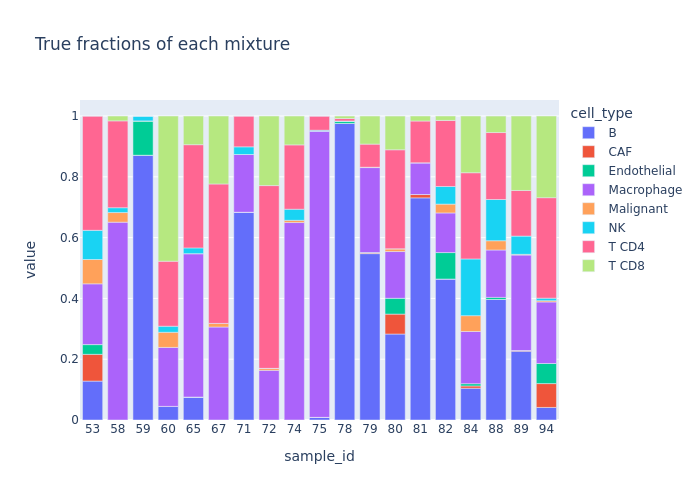

In [14]:
truth_unstacked = truth.unstack("cell_type")["true_fraction"]
cell_types_ungrouped = [c for c in truth_unstacked.columns if c not in ("T", "Lymphocytes")]

fig = px.bar(
    truth_unstacked[cell_types_ungrouped],
    title="True fractions of each mixture"
)

fig.show()

In [15]:
df_preds.unstack("cell_type").loc["normal"].head()

cell_type,B,CAF,Endothelial,Lymphocytes,Macrophage,Malignant,NK,T,T CD4,T CD8
sample_id,,,,,,,,,,
53,0.047628,0.030876,0.056403,0.474483,0.299805,0.138433,0.082886,0.343968,0.343968,0.000000
58,0.000000,0.000000,0.003011,0.285578,0.640688,0.070722,0.021656,0.263922,0.247513,0.016409
59,0.653620,0.000000,0.305489,0.693266,0.000000,0.001245,0.037547,0.002100,0.002100,0.000000
60,0.034159,0.000379,0.000000,0.685847,0.232051,0.081723,0.051040,0.600648,0.203930,0.396718
65,0.085071,0.000728,0.000000,0.660864,0.317211,0.021196,0.033165,0.542628,0.459450,0.083178


In [16]:
df_preds.unstack("cell_type").loc["combine_t_cells"].head()

cell_type,B,CAF,Endothelial,Lymphocytes,Macrophage,Malignant,NK,T,T CD4,T CD8
sample_id,,,,,,,,,,
53,0.044113,0.024257,0.059771,0.141621,0.576183,0.198168,0.097509,0.000000,NaN,NaN
58,0.000000,0.000000,0.000000,0.048550,0.848085,0.103365,0.024763,0.023787,NaN,NaN
59,0.626602,0.000000,0.327470,0.672500,0.000000,0.000030,0.045898,0.000000,NaN,NaN
60,0.035901,0.000477,0.000000,0.491086,0.412484,0.095952,0.053248,0.401937,NaN,NaN
65,0.085412,0.000398,0.000000,0.211721,0.747116,0.040766,0.035150,0.091159,NaN,NaN


## compare experiments: plots of fractions

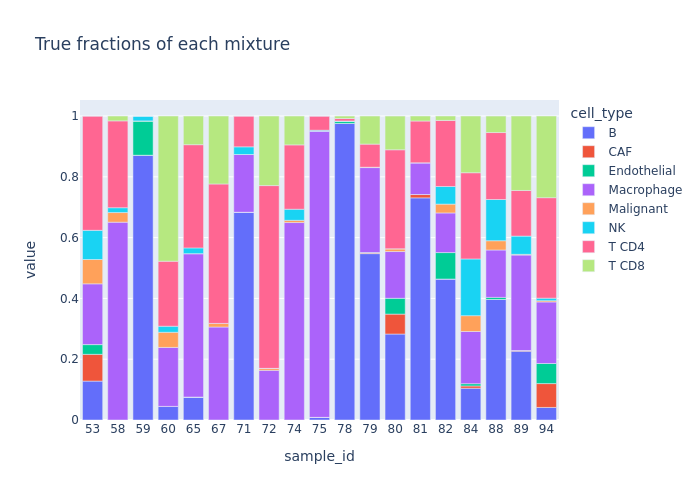

In [17]:
truth_unstacked = truth.unstack("cell_type")["true_fraction"]
cell_types_ungrouped = [c for c in truth_unstacked.columns if c not in ("T", "Lymphocytes")]

fig = px.bar(
    truth_unstacked[cell_types_ungrouped],
    title="True fractions of each mixture"
)

fig.show()

## compute experiments: correlations of cell type fractions

In [18]:
df = all_results.reorder_levels([1, 0], axis=0)

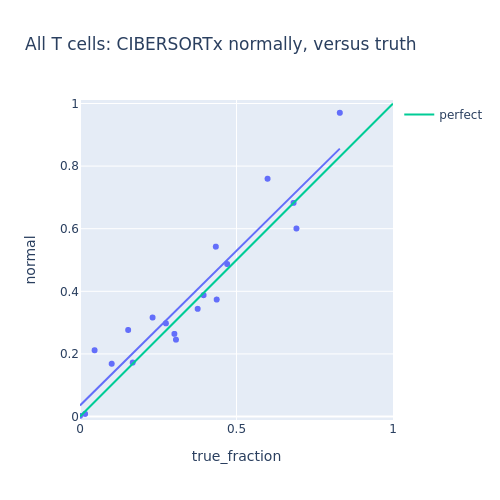

In [33]:
fig = px.scatter(
    df.loc["T"],
    x="true_fraction",
    y="normal",
    title="All T cells: CIBERSORTx normally, versus truth",
    trendline="ols"
)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='perfect'))
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1], scaleanchor = "x", scaleratio = 1)
fig.update_layout(width=500, height=500)
fig.show()

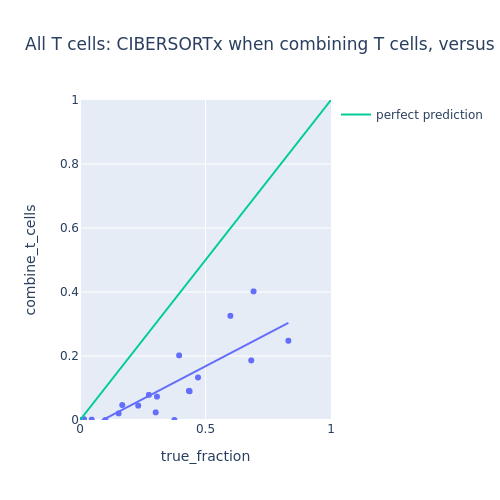

In [20]:
fig = px.scatter(
    df.loc["T"],
    x="true_fraction",
    y="combine_t_cells",
    title="All T cells: CIBERSORTx when combining T cells, versus truth",
    trendline="ols"
)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='perfect prediction'))
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.update_layout(width=500, height=500)
fig.show()

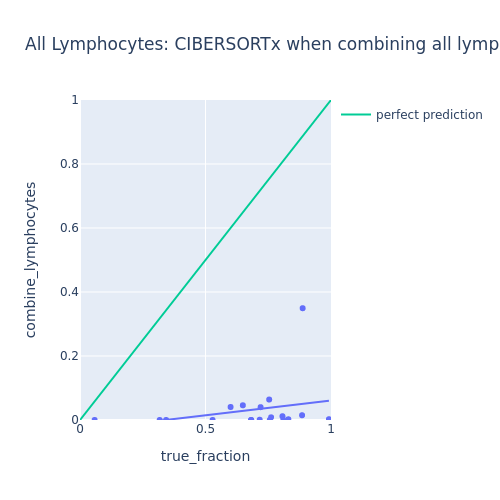

In [21]:
fig = px.scatter(
    df.loc["Lymphocytes"],
    x="true_fraction",
    y="combine_lymphocytes",
    title="All Lymphocytes: CIBERSORTx when combining all lymphocytes (B, NK, T), versus truth",
    trendline="ols"
)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='perfect prediction'))
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.update_layout(width=500, height=500)
fig.show()

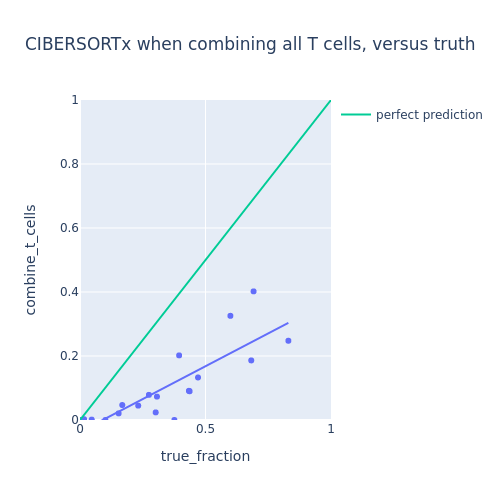

In [22]:
fig = px.scatter(
    df.loc["T"][["true_fraction", "combine_t_cells"]],
    x="true_fraction",
    y="combine_t_cells",
    title="CIBERSORTx when combining all T cells, versus truth",
    trendline="ols"
)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='perfect prediction'))
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.update_layout(width=500, height=500)
fig.show()

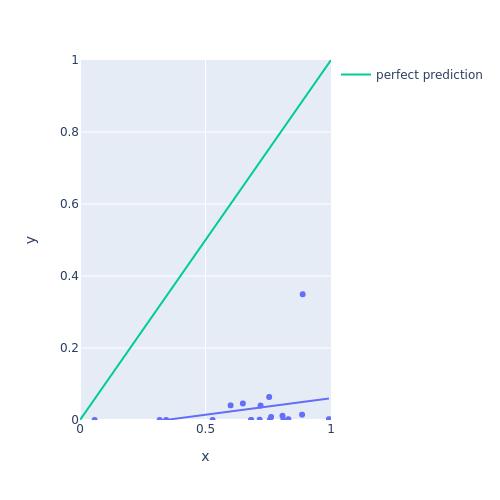

In [23]:
fig = px.scatter(
    x=df.loc["Lymphocytes"]["true_fraction"],
    y=df.loc["Lymphocytes"]["combine_lymphocytes"],
    trendline="ols"
)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='perfect prediction'))
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.update_layout(width=500, height=500)
fig.show()

# Examine overall fractions and ratios of proportions for cell types